# 教師あり学習(分類Ⅲ)
2021/11/09 ver.  


## 分類問題とは

前回の課題に引き続き、退職者予測の分類問題について、機械学習（教師あり学習）を用いて挑戦します。約1500名の従業員の中に含む約250名の退職者から、どのくらいの予測を的中させることができるのでしょうか？

## AI開発ストーリー（再掲載）

あなたは企業の人事担当者です。

従業員の離職は高くつき、損害も大きいです。
そして、能力のある優秀な従業員を引き留めることは、コストの抑制のみならず、競争優位を維持し、知的資本を守るうえでも役に立ちます。

さて、どうやって退職者を事前に予測しましょうか？（そして、早めの引き止め工作をしましょうか…？）


## 0 今回の章でやること（再掲載）
今回の章では、約1500名の社員データから、退職しそうな社員を予測する「退職予測AIモデル」を作成します。

* 1470名中、実際に退職したのは237名でした。
* 1470名の社員に対して、年齢や部署、査定ランクなど全28項目のデータが収集されています。


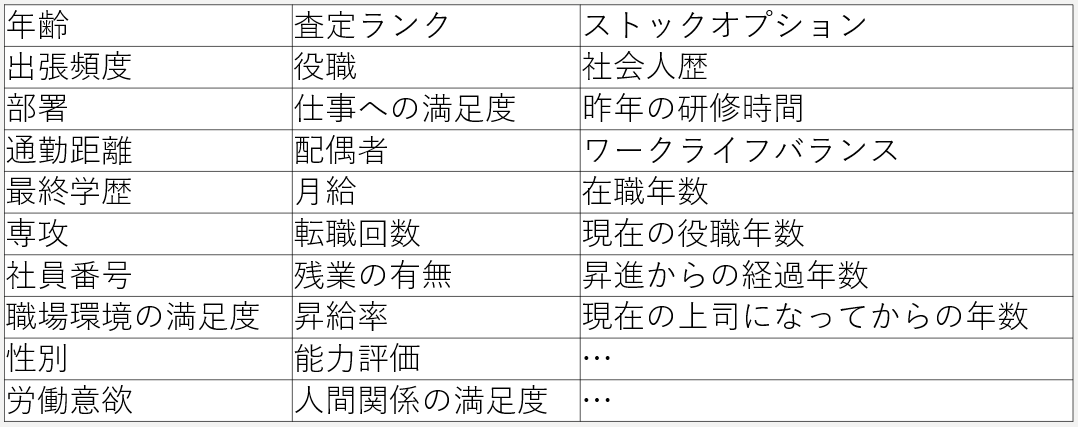

* **補足**：なお、このデータは本物ではなく、IBMのデータサイエンティストが、トレーニング用に作成してくれたものです（ありがたく使わせていただきましょう）
* **参照**：[IBM HR Analytics Employee Attrition & Performance | Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset)

### 0.1 日本語の文字化け（□□□）を訂正（おまじない）


In [ ]:
# 日本語フォントをダウンロードする。
! apt-get -y install fonts-ipafont-gothic

# キャッシュを削除する。
# 削除すべきキャッシュのファイル名は、Matplotlibがバージョンアップすると変わるため、
# 下記のrmでうまく行かない場合、! ls -ll /root/.cache/matplotlib/ でファイル名を確認
# 旧ファイル名：! rm /root/.cache/matplotlib/fontList.json
# 旧ファイル名：! rm /root/.cache/matplotlib/fontlist-v300.json

! rm /root/.cache/matplotlib/fontlist-v310.json   # 2019/10/31段階でのファイル名

### 0.2 ランタイムの再起動（おまじない）

日本語フォントを反映させるため、このタイミングでランタイムを再起動してから、  

→**再起動の方法：Colabメニュー → ランタイム → ランタイムを再起動**　　

再起動後に以降のセルを実行してください

In [ ]:
# 日本語フォントの設定
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

# memo
# plot時に↓のようにフォントを指定する方法もある
# jp_font = {'fontname':'IPAGothic'}
# plt.title('住宅価格のヒストグラム', **jp_font)

-------------

## 1 ライブラリの読み込み～データの読み込み（まとめて実行）
* 解析に使用するライブラリをインポートします。
* 解析対象となる約1500名分の社員データを入手します。
* ダウンロードしたデータを、Pythonの変数（データフレーム）に格納します。
  * 説明変数は `df_employee_x` という変数に格納します。
  * 目的変数は `df_employee_y` という変数に格納します。
* データフレームに格納した最初の3件を表示します。

In [ ]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt   # グラフ描画ライブラリ
import seaborn as sns             # 可視化ライブラリ
import cv2                        # 画像操作ライブラリ

# マジックコマンド
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# sns.set(font="TakaoPGothic")

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')

# 画像サイズの設定
plt.rcParams['figure.figsize'] = (10, 6)

# wgetはウェブサーバからコンテンツを取得するダウンロードコマンドです
! wget https://nai-lab.com/practice/dataset/employee_x_jp.csv
! wget https://nai-lab.com/practice/dataset/employee_y_jp.csv

# 学習用データの読み込み
df_employee_x = pd.read_csv('/content/employee_x_jp.csv')
df_employee_y = pd.read_csv('/content/employee_y_jp.csv')

### 1.1 説明変数の確認

In [ ]:
# 説明変数の冒頭の3件を表示
df_employee_x.head(3)

注釈：前回の演習ではデータを正規化（0～1の範囲に変換）したり、標準化（平均0、分散1に変換）しました。ただ、今回は練習ということもあり、分かりやすさを優先して、あえて**正規化や標準化を行っていない**生データで、機械学習を行います。



**補足**：そして実は、今回採用する機械学習の手法は、正規化や標準化があまり必要のない手法である…という理由もあります。このあたりは手法によって、特徴スケーリング（正規化・標準化）が必要だったり、必要なかったり（やらなくてもそれほど影響がない）するので、興味がある人は、以下、参考リンクなどで調べてみましょう。

* 参考：[決定木は本当に変換に依存しないのか？ - 天色グラフィティ](https://amalog.hateblo.jp/entry/decision-tree-scaling)

### 1.2 目的変数の確認

In [ ]:
# 目的変数を表示
df_employee_y

**重要**：今回はいよいよ、この退職の（Yes、No）を機械学習に予測をさせて、どれだけ良い精度で予測できるかを測定したいと思います。

------------

## 2 目標の設定（再確認）

まず、予測すべき「退職」列を、前回の演習でも使用した`value_counts`というメソッド（機能）を使って、調べてみましょう。

In [ ]:
# 退職の値（と個数）を調べる
df_employee_y.value_counts()

**注釈**：1233名の雇用中（退職していない）の人と、237名の退職者がデータ内に存在することが分かりました。前回の演習では、237名の退職者のうち、**仮に150名でも事前に察知できたなら及第点**ということとして、**150/237名**＝**63%**の精度という、最初の目標を設定することにしました。



**補足**：なお、前回の演習課題で皆さんからいただいた意見では、この及第点は、**50～70％**という意見が多かったです。おおよそ、2/3（66％）ほど正解できれば十分合格ライン！といったところでしょうか？

## 3 データの分割


### 3.1 訓練用と検証用

現在、1470件のデータを2個のデータフレーム（df_employee_x と df_employee_y）に格納しています。  

* `df_employee_x`：10種類の説明変数（1470件）
* `df_employee_y`：退職の「Yes/No」（1470件）



これを今後の目的に合わせて、さらに2種類（合計4個）のデータに分割します。

* `train_x`：AI（モデル）を「訓練」するためのデータ（説明変数）
* `train_y`：AI（モデル）を「訓練」するためのデータ（目的変数）
* `valid_x`：AI（モデル）の精度を「検証」するためのデータ（説明変数）
* `valid_y`：AI（モデル）の精度を「検証」するためのデータ（目的変数）

学校に例えると、「**訓練**」は授業で行う「練習問題」に相当します。練習問題をたくさん解くことで、モデルは賢くなります。 よくAIの分野では「学習」という言葉を耳にしますが、ここでは「学習」と「訓練」は同じ意味で使っています。




そして、どの程度賢くなったかを確認するが「**検証**」で、これは「模擬試験」に相当します。いくら練習問題で高得点を叩き出しても、それは答えを覚えてしまっているダケかもしれませんよね？ですからこの検証用のデータは、AI（モデル）の訓練（学習）には使わずに、隠しておきます（学校の模擬試験も、最初からどんな問題が出題されるか分かってしまったら、真の実力を測ることはできません。それと同じです）

さらに実務では、この「検証」である程度よい成績を収めたモデルを使用して「本試験」…つまり未知である値を実際に予測させて、実運用に耐えうる精度かどうかをテストするという流れになります。


In [ ]:
# データを分割するライブラリを読み込む（おまじない）
from sklearn.model_selection import train_test_split

データを「訓練用」と「検証用」に分割するには、`train_test_split` というメソッド（機能）を使用します。

In [ ]:
# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_employee_x, df_employee_y, train_size=0.7, random_state=0, stratify=df_employee_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

print(
    '訓練データ:',
    train_x.shape,
    train_y.shape,

    '検証データ:',
    valid_x.shape,
    valid_y.shape
)

**注釈：** 1470件のデータを、訓練用データ1029件と、検証用データ441件に分割しました。この割合は、train_test_split関数の`train_size`パラメータで変更できます。今回は`train_size`=**0.7**を指定しましたので、訓練用データを70%、検証用データを30%の割合で分割されました。

この割合に決まった値はありませんが、一般的には**7:3**や**8:2**にすることが多いようです。次の演習①では、8:2の割合で分割する練習をしてみましょう。

### 演習①：データの分割

以下のプログラムの空欄を埋めて、1470件のデータを、**訓練用データ80%**、**検証用データ20%**の割合で分割してみましょう。


In [ ]:
# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_employee_x, df_employee_y, ■空欄■, random_state=0, stratify=df_employee_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

print(
    '訓練データ:',
    train_x.shape,
    train_y.shape,

    '検証データ:',
    valid_x.shape,
    valid_y.shape
)

演習①の成功例は以下の通りです。このようになれば成功です。

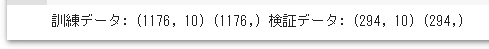

**注釈**：1470件のデータを、訓練用データ1176件、検証用データ294件に分割できれば成功です。

### 3.2 分割後の説明変数

ここで、分割した後の訓練用データ（の説明変数） `train_x` の中身を見てみましょう。

In [ ]:
# 訓練データの説明変数を確認
train_x.head()

**注釈：** 一番左側の**太字の番号**（これをインデックス番号と呼びます）に注目してください。先ほどまではキレイに整列していた左側のインデックス番号が、バラバラになっていることが分かります。訓練データと検証データに偏りが生じることを避けるため、`train_test_split`関数によりシャッフルされたのです。

### 3.3 分割後の目的変数

同様に、ここで、分割した後の訓練用データ（の目的変数） `train_x` の中身を見てみましょう。

In [ ]:
# 訓練データの目的変数を確認
train_y

**注釈**：やはり、左側のインデックス番号がバラバラにシャッフルされていることが確認できます。


ここで、訓練用データと検証用データとで、目的変数のYes,Noの割合が大きく偏りがないかを確認します。

なぜこんな確認をするかと言うと、`train_test_split`メソッドで分割した際に、例えば訓練用データにばかり退職者（Yes）の人が集まってしまい、検証用データには退職者（Yes）の人がほとんどいないような、不均衡なデータで分割されてしまったら、いかがですか？

これでは訓練も検証もあまりよい精度が期待できません。ですから、バランスよくYesとNoが振り分けられていることが望ましいわけです。

In [ ]:
# 訓練用データ（目的変数）の偏りを確認する
np.unique(train_y, return_counts=True)

In [ ]:
# 検証用データ（目的変数）の偏りを確認する
np.unique(valid_y, return_counts=True)

**注釈**：訓練用データが986件のNoと、190件のYes（計算するとYesの割合が約16%）に対して、検証データは247件のNoと、47件のYes（計算すると、こちらも約16%）となり、ほぼ同じYesとNoの割合で分割できていることが確認できました。

**補足**：実は、`train_test_split`メソッドを実行する際に、`stratify`というオプションをつけたのですが、このオプションを付けることで、YesとNoが偏らないようにうまく分割してくれるのです（まめテクニックです）


## 4 AIモデルの訓練

ここまででデータの前処理が（一応）完了しました。※まだ検討の余地はあるかもしれませんので、”一応”としておきます。データの前処理は、この後に続くモデルの精度を左右する重要な作業のため、突き詰めると、まだまだいろいろできそうですが、きりがないので、まずはこの程度で、AIモデルを訓練して検証してみたいと思います。  

AIモデルを訓練するための手法には以下のような様々なアルゴリズムがあります（これでもほんの一部です）

1. ロジスティック回帰
2. **決定木**
3. ランダムフォレスト
4. XGBoost
5. LightGBM
6. Neural Network

まずは、機械学習の「教師あり学習」ののうち、初学者にも理解がしやすい「決定木」の手法から試してみましょう。

## 5 決定木（分類木）

決定木とは、**「不純度」を表すジニ係数を使用して分類していくモデル**です。…という説明で理解できる人の方が少ないと思いますので、ここからじっくりと解説していきます（ご安心ください）

今回は決定木を使って分類をするので、分類木とも呼ばれる手法になります。この手法は、分類していく様を可視化できるという強みがありますので、まずは実際に分類・可視化してから、理論を追いかけて見ましょう。

In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

### 5.1 ハイパーパラメータの設定

機械学習でどのように学習をするのかについて、**あらかじめ人間が設定しておく値**を総称して「ハイパーパラメータ」と呼びます。

今回の決定木では、**木の深さ**というハイパーパラメータを手動で設定します。（それ以外にも、ハイパーパラメータは多数存在するのですが、まずは感覚的に理解しやすい**木の深さ**を例にしましょう）

In [ ]:
# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

### 5.2 学習

いよいよ、機械学習の「学習」を行いましょう。といっても、たった一行で終わってしまうので、拍子抜けしてしまうかもしれませんね）

`fit`というメソッド（機能）に、訓練用データ（の説明変数と目的変数）を渡してあげると、学習が始まります。このとき巨大なデータ（画像や動画などは特に）の場合は、学習に数秒～数分～数時間かかることもありますが、今回は1000件程度（正確には1176件）の数値データですので一瞬で学習が完了します。

In [ ]:
# 学習
dt.fit(train_x, train_y)

**注釈：** 学習が完了すると、学習に使用したハイパーパラメータの一覧が表示されます。この段階ですべてを理解する必要はありませんが、よく見ると、先ほど手動で設定した**木の深さ=2**が`max_depth=2`と正しく設定されていることが確認できます。

**補足**：scikit-learnでは、どの機械学習の手法でも、学習は`fit`メソッド、予測は`predict`メソッドを使うことがほとんどです。そのため、慣れればとても使いやすいのが、開発者にとっての大きなメリットになっています。

### 5.3 可視化

それでは、決定木モデルが、1176件の訓練用データを使った学習を経て、どのような判断で退職者の特徴を捉えたのかを、木を可視化することで確認しましょう。

In [ ]:
# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

**注釈**：実行すると、何やら「Yes、No」チャートのような図が出てきました。これが学習の結果、決定木モデルが退職者と雇用中の人を見分けるために得たルールなのです。

上記の図には少し分かりにくい専門用語も含まれていますので、日本語の注釈を付けたのが以下の画像になります。なお、この図を逆さまにすると、まるで木のような形をしていることから、決定木と呼ばれています。そのため、一番上を木の根っこ（ルート）と表現することもあります。


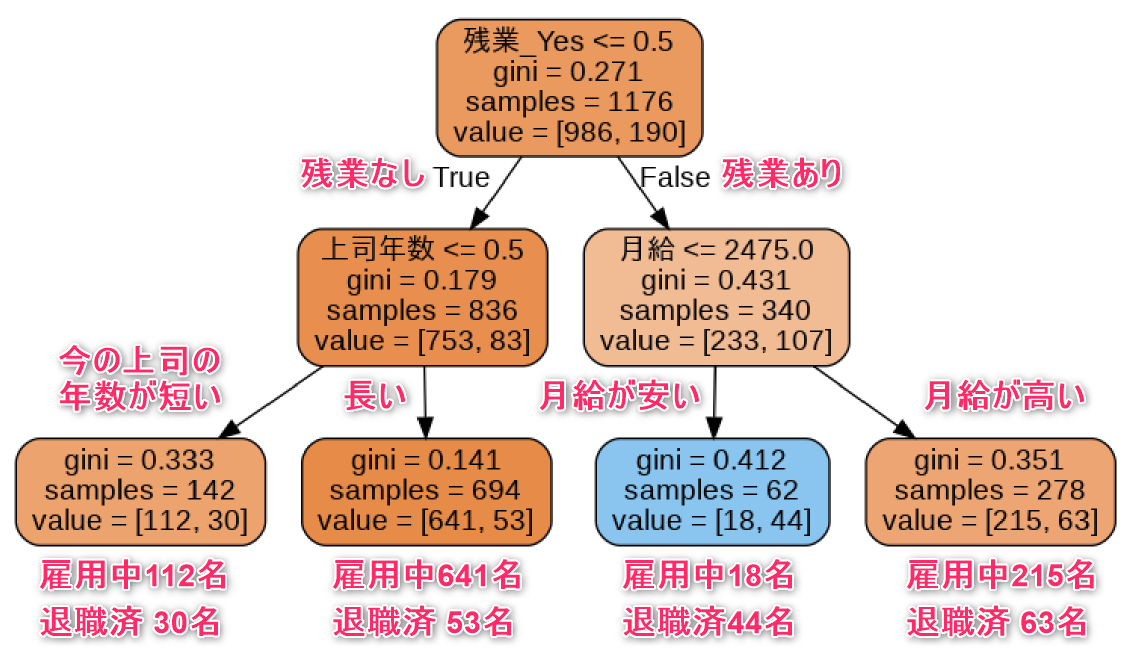

**注釈**：それでは一番上の木の根っこ（ルート）から見ていくことにしましょう。この段階では、データ数（図中の`samples`）は**1176人**あります。そこから最初の指標、つまり一番重要であろう説明変数として決定木がはじき出したの「**残業**」でした（やっぱり！）

ここで**残業なし**の人は木の**左側**へ、**残業あり**の人は木の**右側**に遷移することになります。

図にある`value=[986, 190]`は、1176人中、雇用中の人（退職No)
の人が**986人**、退職済み（退職Yes）の人が**190人**であることを表しています。

**おまけ**：giniとはジニ係数（不順度）と呼ばれる値で、この値が0に近いほど、きれいに美しくデータを分けられていることを表しています。このジニ係数についてガチると数学の知識が必要になるのでここでは割愛しますが、まずは「0に近いほどイイ木なんだな」といった程度で理解しておきましょう。


続いて、残業なし（左側）に注目しましょう。ここには1176名中、836名の社員が振り分けられました（`samples=836`）そして、次の振り分けの指標が`上司年数`です。これは現在の上司になってからの年数を表す説明変数でしたが、これが**短い**（つまり最近、上司が変わった）人は**左側**へ、長い（いまの上司との付き合いが長い）人は**右側**へ遷移します（「上司」は、仕事の人間関係の中でもウエイトが重いですからね…）

さて、次に3段目に目を移します。

一番左下には、142名（`samples=142`）の社員が振り分けられています。この人たちは**「残業がなくて、最近上司が変わった人」**です。退職者の割合を計算すると142名に対して退職済み30名ですから、30/142=**約21%**の退職率です。

左から二番目には、694名（`samples=694`)の社員が振り分けられています。この人たちは**「残業がなくて、長らく上司が変わっていない人」**です。退職者の割合を計算すると694名に対して退職済み53名ですから、53/694=**約8%**の退職率です。

これだけを比較すると、同じく残業がない人たちの中でも、上司との人間関係（慣れている上司の方が仕事がやりやすいのでしょうか）によって、離職率が随分と違うことが読み取れます。

そして、特筆すべきは3段目の左から3番目（水色で目立つマスです）ここは**「残業があるのに、月給が安い」**というちょっと**ブラックな環境**の方々です。ここには62名（`samples=62`)の社員が振り分けられていますが、退職者の割合を計算すると62名に対して退職済み44名ですから、53/694=**約70%**の退職率です。なんとまあ、**驚異の退職率**です。

参考：

* [【機械学習】決定木をscikit-learnと数学の両方から理解する - Qiita](https://qiita.com/Hawaii/items/53efe3e96b1171ebc7db)

* [決定木をいろいろな方法で可視化する - 静かなる名辞](https://www.haya-programming.com/entry/2019/06/25/235927)

### 演習②：決定木の深さ

以下のプログラムの空欄を埋めて、好きな深さ（3以上）で決定木を作りましょう。


In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

# ハイパーパラメータの設定（今回は木の深さを「3以上」に設定する）
dt = DecisionTreeClassifier(max_depth=■空欄■, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

### 演習③：決定木の考察

上の演習②で作成した決定木（深さ3以上）を見て、感じたこと思ったこと、そこから読み解けそうなことなどなど、なんでも自由に考察して記してください。


### 5.4 予測



それではいよいよ1176件の訓練用データで学習を行った決定木のモデルで、294件の検証用データについて、予測をしてみましょう。この段階で決定木のモデルは、294件の検証用データの答え（Yes、No）は知りません。さてさて、どのくらい当てることができるのでしょうか…！

In [ ]:
# 次の演習のために木の深さ2で、再度学習をしなおしておく
dt = DecisionTreeClassifier(max_depth=2, random_state=0)
dt.fit(train_x, train_y)

# 予測
dt_pred = dt.predict(valid_x)

**注釈**：予測は`predict`というメソッド（機能）を使って行います。が、これ（上記のセル）を実行しても何も応答はありません。しかし、決定木の予測した回答は、`dt_pred`という変数の中にすでに格納されています。では、その`dt_pred`の中身を確認してみましょう。

In [ ]:
# 予測
print('決定木の予測（全294件）：\n{}'.format(dt_pred[0:-1]))

**注釈**：でました！これが**正解を教えていない**検証用データに対して、決定木が予測した回答（Yes、No）が上記です。パッと見たところ、`No`が多く、ときどき`Yes`がある感じでしょうか…。ここから、この予想がどのくらい当たっていたのかを検証していきましょう。


### 5.5 精度評価

このセクションでは、機械学習モデル（今回は決定木）の予測精度を測定します。まずは、予測結果と実際の退職結果（正解）を見比べてみましょう。

In [ ]:
# 予測結果と正解の比較
print('決定木での予測（先頭10件のみ）：{}'.format(dt_pred[0:10]))
print('実際の退職結果（先頭10件のみ）：{}'.format(np.array(valid_y[0:10])))

**注釈：** 予測と正解を見比べてみてどうでしょう。**それほど悪くない**精度に見えますが、最初の10件だけでは精度の判断がしにくいですので、検証データ(今回は294件）のすべてに対して、精度（正解率）を測定してみましょう。

`accuracy_score`というメソッド（機能）を使うと、正解率を簡単に算出することができます。

In [ ]:
y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

from sklearn.metrics import accuracy_score  # ライブラリのインポート（おまじない）
print(accuracy_score(y_true, y_pred)) # 正解率を測定する

**注釈**：精度を測定したところ、なんと**約84%**という高い正解率を叩き出すことができました！（やりました！）

### 5.6 正解率の罠

しかし、ここで少しストップ！**一度立ち止まりましょう**。経験上、最初からこんなに良い精度が出てしまうのは少し**怪しい**匂いがします。ここで今一度、先程の予測結果と正解の比較を再掲載します。

In [ ]:
# 予測結果と正解の比較
print('決定木での予測（先頭10件のみ）：{}'.format(dt_pred[0:10]))
print('実際の退職結果（先頭10件のみ）：{}'.format(np.array(valid_y[0:10])))

**注釈**：1行目の決定木での予測をよーく見てみましょう。すべてが、Noになっています。決定木では、最初の10名に対して全員が「No（退職しない）」と予測しています。この辺で少し嫌な予感がするのですが、決定木での予測を、もう一度、全件見直してみます。

In [ ]:
# 予測
print('決定木の予測（全294件）：\n{}'.format(dt_pred[0:-1]))

**注釈**：件数が多くなったので少し分かりにくいですが、Noに比べてYes（退職すると予測）が**圧倒的に少ないような感じ**がします。そんな「感じ」がしたら、きちんとデータを計測して裏取りをしましょう。

以下のように、`unique`メソッドで、NoとYesの件数を測定します。

In [ ]:
np.unique(dt_pred, return_counts=True)

**注釈**：Noと予想したのが287件に対して、Yesと予測したのがたったの7件です。割合を計算すると、7/294=約**2%**という少なさです。これは何かマズイことが起きている気がします。

そもそも、元のデータは1470名中、237名の退職者がいましたので、実際は237/1470=**16%**ほどの退職率でした。それなのに、決定木が「離職する」と予想したのは、たった**2%**だけ…けれども、正解率を測定すると約**84%**のハイスコア…これはいったいどういうことなのでしょうか？

**重要**：そこには、精度評価の指標として「正解率」を使った場合の注意点が隠されています。

そもそも、事実として16%の退職者がいたということは、退職していない（雇用中）人は全体の84%になります。

このとき、AIが何も考えずに「仕事を辞める人はいない！全員、退職はしない！」と超強気の予想（？）をしたとしましょう。つまり予想は100%が「No」という状態です。こんな無茶苦茶な予想（？）であっても、84%はもともと退職していないワケですから、正解率はなんと、84%になってしまうワケです（そんなズルイ！）

言われてみれば当たり前なのですが、このようなミスを結構、やってしまうことがあります。精度評価の指標として「正解率」だけを追い求める危険性をおわかりいただけたでしょうか？

### 5.7 再現率

このように、YesとNoのバランスが悪いデータを**不均衡データ**と呼びます。不均衡データで予測する場合は、正解率だけですと前述のような怪しげな結果になりますので、別な精度評価の指標も組み合わせるのが一般的です。



ここでは「再現率（回収率とも呼ばれます）」という評価指標をご紹介します。今回のケースにおいて再現率は**「本当に退職した人の中から、AIが退職すると予想できた人の割合」**になります。つまり退職しなかった人は、この再現率では考慮する必要がありません。

冷静に考えると、今回は「退職者をいかに早期に発見するか」が重要でしたので、退職しなかった人は置いておいても、まずは退職した人に注目して、それをいかに見つけていくか（回収するか）が重要なわけです。そういう意味では前述の「正解率」よりも、この「再現率（回収率）」のほうが、今回使用する指標としては適切な気がしませんか？





補足：精度を評価する指標には他にも「適合率」「F1値」などがありますが、こちらも必要に応じて学習していきましょう。

参考：[【入門者向け】機械学習の分類問題評価指標解説(正解率・適合率・再現率など) - Qiita](https://qiita.com/FukuharaYohei/items/be89a99c53586fa4e2e4)

それでは早速、今回の決定木の予想について、正解率ではなく「再現率」で、精度を測定してみましょう。

recall_scoreというメソッド（機能）を使うと、再現率を簡単に算出することができます。

In [ ]:
from sklearn.metrics import recall_score  # ライブラリのインポート（おまじない）
print(recall_score(y_true, y_pred))  # 再現率を測定する

注釈：おっと、85%！…ではなく、よく見ると桁が一桁違います。なんと、なんと、再現率は8.5%（ガガーン）

237名の退職者がいるとすると、なんとこの決定木ではそのうちの20名程度しか、見つけることができないことになります（これでは人事部の上司にめっちゃ怒られます！）

よくある「AIに過度な期待を寄せたら、裏切られて、失望した」というパターンになってしまいました。これを何とかする方法はあるのでしょうか？

### 5.8 チューニング

このような残念な結果になってしまった場合、対策を考えて、実際に試して、精度向上を目指します。よく行う対策のうちの一つであるハイパーパラメータのチューニングを試してみます。

以下は少し長いコードが書いてありますが、慌てないでください。いままでのコードを一つのセル内にまとめただけです。ここで皆さんには、決定木のハイパーパラメータである「木の深さ」をいろいろと変えてみて、どのような精度（正解率・再現率）になるのかをトライしていただきたいと思います。

### 演習④：木のチューニング

以下のプログラムの空欄を埋めて、様々な木の深さ（3以上）で、精度を測定します。

その結果を元に、木の深さと精度（正解率・再現率）の関係や、いろいろと試してみて、気がついたこと、思ったこと、なんでも自由に、まとめてみましょう。


In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

# ハイパーパラメータの設定
#今回は木の深さを「いろいろな値」に設定して、何度も試してみよう）
dt = DecisionTreeClassifier(max_depth=■空欄■, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

from sklearn.metrics import accuracy_score  # ライブラリのインポート（おまじない）
print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！') # 正解率を測定する

from sklearn.metrics import recall_score  # ライブラリのインポート（おまじない）
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')  # 再現率を測定する

### 5.9 ここまでのまとめ

いかがでしょうか？　決定木の深さを様々にチューニングした結果、精度が変わることが確認できたと思います。ただし、それでもおそらく、満足の行く精度（特に再現率は）にならなかったのではないでしょうか？（これでは、やっぱり人事部の上司に怒られてしまいます…）

いったい、どうしたらよいのでしょうか？

### 演習⑤：チューニングの考察



今回は満足のいく結果が出せませんでした。しかし、ここで諦めてはデータサイエンティスト（AIエンジニア）としては仕事になりません！　次回以降の演習では、なんとか、これを改良していく手段を考えていきたいと思います。

そこで、みなさんならどのような方法で、この精度を上げようと思いますか？　もちろん専門的な答えでなくて結構です。理論的に正しい必要もありません。とにかく、なんでも思いついたアイデアで結構ですので、自由に意見をお寄せください。お寄せいただいたいたアイデアの中からいくつかを選んで、次回以降の演習で試してみたいなと考えています。

直感的にパッと思いついたアイデアでも、理論的に考えたアイデアでもなんでも、そしていくつでも結構です。みなさんからのご意見を広く募集します！


---